In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
GITHUB_CDN = "https://raw.githubusercontent.com/realamirhe/github-stargazer"

tens = range(1, 10)

js_repo_urls = map(lambda idx: f"{GITHUB_CDN}/master/data/js-{idx}.csv", tens)
py_repo_urls = map(lambda idx: f"{GITHUB_CDN}/master/data/py-{idx}.csv", tens)
first_chunk_url =  f"{GITHUB_CDN}/master/data/datas.csv"
second_chunk_url =  f"{GITHUB_CDN}/master/data/datas-2.csv"

data_urls = [*js_repo_urls, *py_repo_urls, first_chunk_url, second_chunk_url]

In [49]:
datas = pd.concat(list(map(pd.read_csv, data_urls)))
datas = datas.select_dtypes(exclude=['object'])
datas = datas.reset_index()
datas = datas.drop_duplicates()
datas = datas.drop(columns=['index', 'Unnamed: 0', 'score'], axis=1)
datas = datas.replace({ False: 0, True: 1 })
datas.head()

,private,owner.public_repos,owner.public_gists,owner.followers,owner.following,fork,forks,size,stargazers_count,watchers_count,...,has_pages,has_discussions,forks_count,archived,disabled,open_issues_count,allow_forking,is_template,web_commit_signoff_required,watchers
0,0,64,62,23302,11,0,540,7954,1962,1962,...,0,0,540,0,0,30,1,0,0,1962
1,0,274,758,10063,11,0,61,3462,435,435,...,0,0,61,0,0,13,1,0,0,435
2,0,50,0,11,0,0,605,168196,3031,3031,...,0,0,605,0,0,15,1,0,0,3031
3,0,64,62,23302,11,0,516,2639,2200,2200,...,1,0,516,0,0,247,1,0,0,2200
4,0,58,50,195,16,0,7,192,68,68,...,0,0,7,0,0,1,1,0,0,68


In [20]:
import seaborn as sns

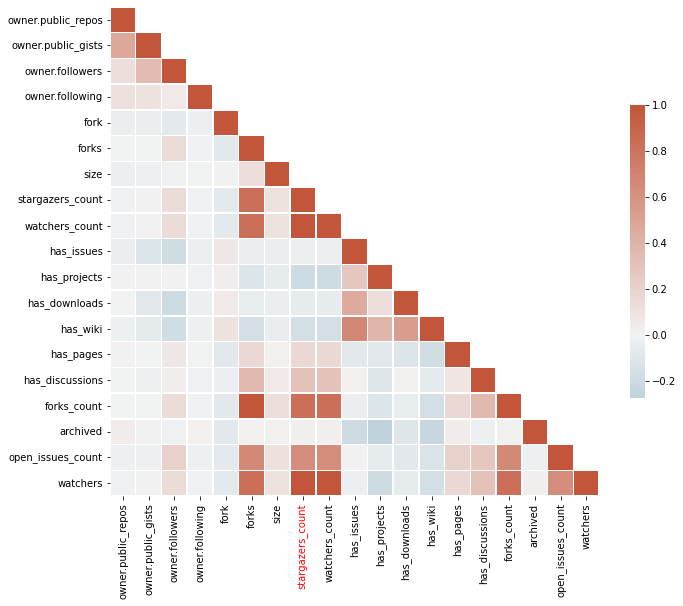

In [48]:
keep = [c for c in list(datas) if len(datas[c].unique()) > 1]
corr = datas[keep].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax1 = sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .6})

for tick_label in ax1.xaxis.get_ticklabels():
  tick_label.set_color('red' if tick_label.get_text() == 'stargazers_count' else 'black')